In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import truncnorm

random.seed(10)
np.random.seed(seed=10)

def get_truncated_normal(mean=0, sd=1, low=0, upp=1): # why mean = 0.5 才會有相同結果？！
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs()

class agent:
    # static variables
    M = 10 # time horizon
    def __init__(self, latice, index, innovation_num, a, b, K, I, S, i):
        self.index = index
        self.innovation_num = innovation_num
        self.a = a # Alpha
        self.b = b # Beta
        self.K = K # market position of firm
        self.I = I # Inertia
        self.S = S # Skepticsim
        self.i = i # what innovation firm take
        self.innovation_record = [self.i]
        self.performance_record = [self.get_performance(latice)]
        self.abandonment_record = []

    def get_performance(self, lattice):
        return (self.a * self.K) + (self.b * lattice.get_value_of_innovation(self.i)) + ((1-self.a-self.b) * get_truncated_normal())
    
    def take_action(self, lattice, t, w, Nw):
        # make abandon decision
        if self.abandon_decision():
            # add abandonment record
            if len(self.abandonment_record) == self.M:
                self.abandonment_record.pop(0)
            self.abandonment_record.append((self.i, t))

            # make adpot decision
            if self.i != w:
                if self.adopt_decision(t, w, Nw):
                    self.i = w
                else:
                    self.i = random.randint(0, self.innovation_num-1) # draw a new innovation at random
            else:
                self.i = random.randint(0, self.innovation_num-1) # draw a new innovation at random

        # update records
        if len(self.innovation_record) == self.M:
            self.innovation_record.pop(0)
            self.performance_record.pop(0)
        self.innovation_record.append(self.i) 
        self.performance_record.append(self.get_performance(lattice))

    def abandon_decision(self):
        n_ti = self.innovation_record.count(self.i) # number of trials within recent memory when a firm has used innovation i
        C_fit = 1 - (self.I ** (0.25 * n_ti)) # firm’s confidence in its ability to assess the effect of innovation i.
        if self.I == 0: C_fit = 1

        Oft_sum = 0
        for i, val in enumerate(self.innovation_record):
            if val == self.i:
                Oft_sum += self.performance_record[i]
        Oft = Oft_sum / n_ti # mean performance of the firm over each use of innovation i in the past M iterations
        
        abandon_prob = (1 - Oft) * C_fit # probability that firm f will abandon its present innovation at time t
        abandon = random.choices([True, False], weights=[abandon_prob, 1-abandon_prob])[0]
        return abandon

    def adopt_decision(self, t, w, Nw):
        if self.S == 0:
            R_ext = 1
            R_int = 1
        else:
            R_ext = 1 - (self.S ** (0.25 * Nw)) # componect related to the innovation’s “external” success with others           
            R_int = 1 # component related to the "internal" experience the firm may have had with the winning innovation
            tw = -1
            for i in self.abandonment_record:
                if i[0] == w:
                    tw = t - i[1]
            if tw != -1:
                R_int = 1 - (self.S ** (0.25 * tw))
        
        adopt_prob = R_ext * R_int  
        adopt = random.choices([True, False], weights=[adopt_prob, 1-adopt_prob])[0]
        return adopt


class lattice:
    M = 10 # time horizon
    def __init__(self, N, a, b, I, S, innovation_num = -1):
        self.N = N
        self.t = 1
        
        if innovation_num == -1: # Defualt
            self.innovation_num = 1000
        else:
             self.innovation_num = innovation_num
        self.innovations_value = []
        for i in range(self.innovation_num):
                self.innovations_value.append(get_truncated_normal())

        self.agents = []
        for i in range(N):
            if I == -1 and S == -1: # get I and S from normal distribution of expectaion = 0.5
                self.agents.append(agent(self, i, self.innovation_num, a, b, get_truncated_normal(), get_truncated_normal(mean=.5), get_truncated_normal(mean=.5), random.randint(0, self.innovation_num-1)))
            else:
                self.agents.append(agent(self, i, self.innovation_num, a, b, get_truncated_normal(), I, S, random.randint(0, self.innovation_num-1)))

        innovations = self.get_innovation_of_all_agents()
        leading_innovation = max(set(innovations), key = innovations.count)
        self.leaing_record = [leading_innovation]
        self.winnig_reocrd = []
    
    def get_value_of_innovation(self, i):
        return self.innovations_value[i]

    def one_round(self):
        self.t += 1

        # Find winning innovation
        w = -1
        who_has_w = -1
        performance_temp = -1
        for i in range(self.N):
            p = self.agents[i].performance_record[-1]
            if p > performance_temp:  # 如果有複數個公司有相同高performance的話怎麼辦？
                performance_temp = p
                who_has_w = i
                w = self.agents[i].i

        if self.t == 2:
            self.winnig_reocrd.append((w, who_has_w))

        win_with_w = set()
        for i in self.winnig_reocrd:
            if i[0] == w:
                win_with_w.add(i[1])
        Nw = len(win_with_w)

        # loop over all agents
        for i in range(self.N):
            self.agents[i].take_action(self, self.t, w, Nw)
        
        # Find leading innovation
        innovations = self.get_innovation_of_all_agents()
        leading_innovation = max(set(innovations), key = innovations.count)
        self.leaing_record.append(leading_innovation)

        # record winnig innovation
        if len(self.winnig_reocrd) == self.M:
            self.winnig_reocrd.pop(0)
        self.winnig_reocrd.append((w, who_has_w))

    def get_innovation_of_all_agents(self):
        innovations = []
        for i in range(self.N):
            innovations.append(self.agents[i].i)
        return innovations

    def get_performance_of_all_agents(self):
        performances = []
        for i in range(self.N):
            performances.append(round(self.agents[i].performance_record[-1], 2))
        return performances

    def get_popularity(self):
        innovations = self.get_innovation_of_all_agents()
        return innovations.count(max(set(innovations), key = innovations.count))

    def get_turnover(self, end):
        l = self.leaing_record[end-99]
        turnover_num = 0
        for i in range(end-99, end+1):
            if l != self.leaing_record[i]:
                turnover_num += 1
            l = self.leaing_record[i]
        return turnover_num

# Experiment 1

In [2]:
N = 100
round_num = 200
trial_num = 100

log_innovations_all = []
log_popularity_all = []
log_turnover_all = []

for i in range(trial_num):
    MyLattice = lattice(N, 0, 0, 0, 0)
    log_innovations = []
    log_popularity = []
    log_turnover = []
    for t in range(round_num):
        MyLattice.one_round()
        log_innovations.append(MyLattice.get_innovation_of_all_agents())
        log_popularity.append(MyLattice.get_popularity())
        if t == 99 or t == 199:
            log_turnover.append(MyLattice.get_turnover(t))
    
    log_innovations_all.append(log_innovations)
    log_popularity_all.append(sum(log_popularity) / len(log_popularity))
    log_turnover_all.append(sum(log_turnover) / len(log_turnover))

In [3]:
print("Number of innovation:", MyLattice.innovation_num)
print("Number of trial:", trial_num)
print()

popularity_array = np.array(log_popularity_all)
turnover_array = np.array(log_turnover_all)

print("             Mean  |  Std  |  Min  |  Max ")
print("Popularity:", round(popularity_array.mean(), 3), " ", round(popularity_array.std(), 3), " ", min(popularity_array), " ",  max(popularity_array))
print("Turnover:", " ", round(turnover_array.mean(), 3), " " , round(turnover_array.std(), 3), " ", min(turnover_array), "   ",  max(turnover_array))

Number of innovation: 1000
Number of trial: 100

             Mean  |  Std  |  Min  |  Max 
Popularity: 49.67   0.355   48.825   50.495
Turnover:   50.26   4.032   43.0     63.0


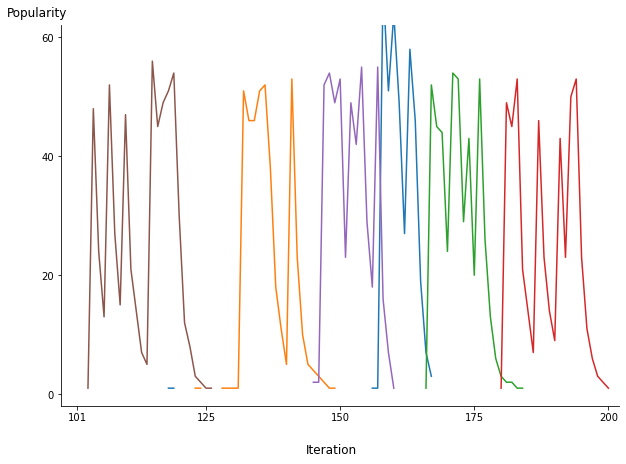

In [4]:
log = log_innovations_all[9]
log_array = np.array(log[100:]).flatten()
leading_innovations = [pair[0] for pair in sorted(Counter(log_array).items(), key=lambda item: item[1])][-6:] # six leading innovations

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

x = np.arange(101, 201)
for l in leading_innovations:
    y = np.array([])
    for t in log:
        y = np.append(y, t.count(l))
    y[y == 0] = np.nan
    ax.plot(x, y[100:])
    
ax.set_ylim(-2, 62)
ax.set_yticks(np.array([0, 20, 40, 60]))
ax.set_xlim(98, 202)
ax.set_xticks(np.array([101, 125, 150, 175, 200]))
ax.tick_params(direction="out")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Popularity", rotation=0, y=1.015, fontsize=12)
fig.set_facecolor('white')
plt.suptitle("Iteration", y=0.05, fontsize=12)
plt.show()

# Experiment 2

In [5]:
N = 100
round_num = 200
trial_num = 10

parameters = []
for i in range(11):
    parameters.append(i/10)

# By skeptiesim
log_popularity_skeptiesim = []
log_turnover_skeptiesim = []

for s in parameters:
    popularity = []
    turnover = []
    for trail in range(trial_num):
        MyLattice = lattice(N, 0, 0, 0, s)
        log_popularity = []
        log_turnover = []
        for t in range(round_num):
            MyLattice.one_round()
            log_popularity.append(MyLattice.get_popularity())
            if t == 99 or t == 199:
                log_turnover.append(MyLattice.get_turnover(t))
        popularity.append(sum(log_popularity) / len(log_popularity))
        turnover.append(sum(log_turnover) / len(log_turnover))

    log_popularity_skeptiesim.append(sum(popularity) / len(popularity))
    log_turnover_skeptiesim.append(sum(turnover) / len(turnover))

# By inertia
log_popularity_inertia = []
log_turnover_inertia = []

for i in parameters:
    popularity = []
    turnover = []
    for trail in range(trial_num):
        MyLattice = lattice(N, 0, 0, i, 0)
        log_popularity = []
        log_turnover = []
        for t in range(round_num):
            MyLattice.one_round()
            log_popularity.append(MyLattice.get_popularity())
            if t == 99 or t == 199:
                log_turnover.append(MyLattice.get_turnover(t))
        popularity.append(sum(log_popularity) / len(log_popularity))
        turnover.append(sum(log_turnover) / len(log_turnover))

    log_popularity_inertia.append(sum(popularity) / len(popularity))
    log_turnover_inertia.append(sum(turnover) / len(turnover))

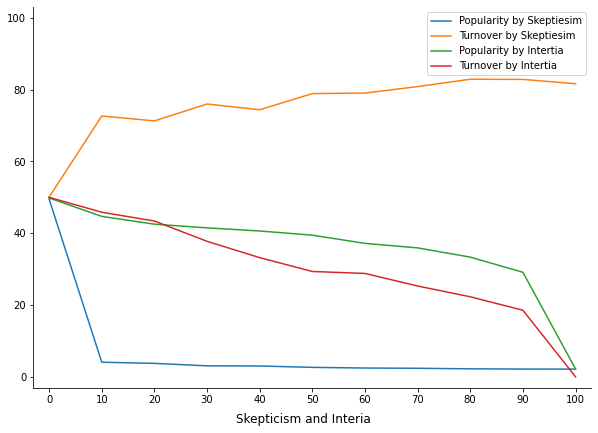

In [6]:
x = np.arange(0, 101, 10)

y1 = np.array(log_popularity_skeptiesim)
y2 = np.array(log_turnover_skeptiesim)
y3 = np.array(log_popularity_inertia)
y4 = np.array(log_turnover_inertia)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(x, y1, label="Popularity by Skeptiesim")
ax.plot(x, y2, label="Turnover by Skeptiesim")
ax.plot(x, y3, label="Popularity by Intertia")
ax.plot(x, y4, label="Turnover by Intertia")

ax.set_ylim(-3, 103)
ax.set_yticks(np.array([0, 20, 40, 60, 80, 100]))
ax.set_xlim(-3, 103)
ax.set_xticks(np.arange(0, 101, 10))
ax.tick_params(direction="out")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
fig.set_facecolor('white')
plt.suptitle("Skepticism and Interia", y=0.075, fontsize=12)
plt.show()

# Experiment 3

In [7]:
N = 100
round_num = 200
trial_num = 10

parameters = []
for i in range(11):
    parameters.append(i/10)

log_popularity_beta = []
log_turnover_beta = []

for b in parameters:
    popularity = []
    turnover = []
    for trial in range(trial_num):
        MyLattice = lattice(N, 0, b, -1, -1)
        log_popularity = []
        log_turnover = []
        for t in range(round_num):
            MyLattice.one_round()
            log_popularity.append(MyLattice.get_popularity())
            if t == 99 or t == 199:
                log_turnover.append(MyLattice.get_turnover(t))
        popularity.append(sum(log_popularity) / len(log_popularity))
        turnover.append(sum(log_turnover) / len(log_turnover))

    log_popularity_beta.append(sum(popularity) / len(popularity))
    log_turnover_beta.append(sum(turnover) / len(turnover))

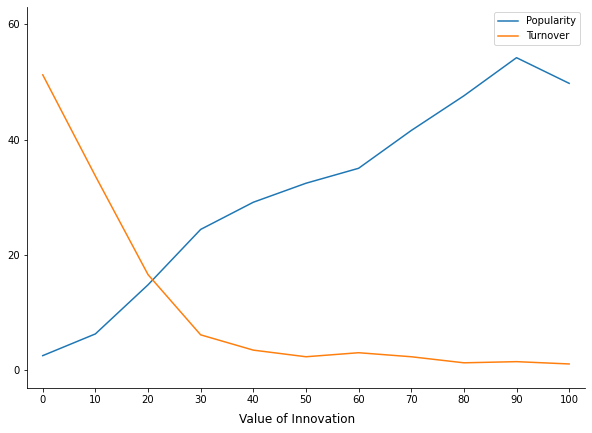

In [8]:
x = np.arange(0, 101, 10)

y1 = np.array(log_popularity_beta)
y2 = np.array(log_turnover_beta)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(x, y1, label="Popularity")
ax.plot(x, y2, label="Turnover")

ax.set_ylim(-3, 63)
ax.set_yticks(np.array([0, 20, 40, 60]))
ax.set_xlim(-3, 103)
ax.set_xticks(np.arange(0, 101, 10))
ax.tick_params(direction="out")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
fig.set_facecolor('white')
plt.suptitle("Value of Innovation", y=0.075, fontsize=12)
plt.show()

# Experiment 4

In [9]:
N = 100
round_num = 200
trial_num = 10

parameters = []
for i in range(11):
    parameters.append(i/10)

log_popularity_alpha = []
log_turnover_alpha = []

for a in parameters:
    popularity = []
    turnover = []
    for trial in range(trial_num):
        MyLattice = lattice(N, a, 0, -1, -1)
        log_popularity = []
        log_turnover = []
        for t in range(round_num):
            MyLattice.one_round()
            log_popularity.append(MyLattice.get_popularity())
            if t == 99 or t == 199:
                log_turnover.append(MyLattice.get_turnover(t))
        popularity.append(sum(log_popularity) / len(log_popularity))
        turnover.append(sum(log_turnover) / len(log_turnover))

    log_popularity_alpha.append(sum(popularity) / len(popularity))
    log_turnover_alpha.append(sum(turnover) / len(turnover))

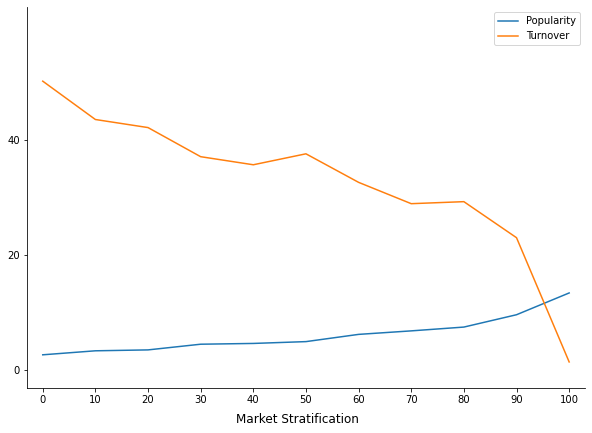

In [10]:
x = np.arange(0, 101, 10)

y1 = np.array(log_popularity_alpha)
y2 = np.array(log_turnover_alpha)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(x, y1, label="Popularity")
ax.plot(x, y2, label="Turnover")

ax.set_ylim(-3, 63)
ax.set_yticks(np.array([0, 20, 40]))
ax.set_xlim(-3, 103)
ax.set_xticks(np.arange(0, 101, 10))
ax.tick_params(direction="out")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
fig.set_facecolor('white')
plt.suptitle("Market Stratification", y=0.075, fontsize=12)
plt.show()